# [In Progress]

# Programación Entera: Heurísticas para Problemas de Redes

## Descripción

[TODO]

## Autor
  
  * Sergio García Prado - [garciparedes.me](https://garciparedes.me)
  
## Fecha

  * Mayo de 2018


## Contenidos
  
  * [Introducción](#Introducción)
  * [Problemas De Redes](#Problemas-de-Redes)
    * [Flujo de Redes con Costes Fijos](#Flujo-de-Redes-con-Costes-Fijos)
    * [Árbol Recubridor Mínimo](#Árbol-Recubridor-Mínimo)
    * [Árbol Recubridor Mínimo Capacitado](#Árbol-Recubridor-Mínimo-Capacitado)
    * [Problema de Steiner](#Problema-de-Steiner)
  * [Conclusiones](#Conclusiones)

## Introducción

TODO

In [1]:
rm(list = ls())

In [2]:
library(slam, warn.conflicts = FALSE)
library(Rglpk, warn.conflicts = FALSE)
library(purrr, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(magrittr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(ggthemes, warn.conflicts = FALSE)
library(scales, warn.conflicts = FALSE)
library(igraph, warn.conflicts = FALSE)
library(gridExtra)

Using the GLPK callable library version 4.65

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [3]:
options(repr.matrix.max.rows = 600, repr.matrix.max.cols = 600)

#### Constantes y Funciones de Apoyo

In [4]:
dataset.root <- "./data/"
dataset.folder <- paste0(dataset.root, "network/")
dataset.mosel <- paste0(dataset.folder, "mosel/")

In [5]:
simple.file.names <- c("gr15_1.dat", "gr15_2.dat", "gr15_3.dat", "gr15_4.dat", "gr15_4.dat" )

In [6]:
Solve <- function(...) {
    Rglpk_solve_LP(...)
}

In [7]:
ReadRaw <- function(file.path) {
    con <- 
        file.path %>%
        file(open = "r")
    raw <- 
        con %>%
        readLines(warn = FALSE) %>% 
        strsplit("[[:blank:]]+") %>%
        unlist() %>%
        as.double()
    close(con)
    return(raw)
}

In [8]:
Format1DFixedCostNetworkSolution <- function(s, p) {
    
    if (length(s$solution) %% p$n == 0) {
        n <- p$n 
    } else {
        n <- p$n + 1
    }
    l <- list(
        min.cost = s$optimum,
        quantity = matrix(s$solution[1:(n ^ 2)], ncol = n, byrow = TRUE),
        edge     = matrix(s$solution[(n ^ 2 + 1):(2 * n ^ 2)], ncol = n, byrow = TRUE)
    )
    
    if (length(a$solution) > (2 * n ^ 2)) {
        l$node <- matrix(s$solution[(2 * n ^ 2 + 1):(2 * n ^ 2 + n)], ncol = n, byrow = TRUE)
    }
    return(l)
}

In [9]:
ReadCoordinatedFile <- function(file.path) {
    raw <- 
        file.path %>%
        ReadRaw()
    a <- matrix(0, nrow = raw[1], ncol = 2)
    a[, 1] <- raw[1 + seq(2, to = length(raw), by = 3)]
    a[, 2] <- raw[1 + seq(3, to = length(raw), by = 3)]
    
    return(a)
} 

## Problemas de Redes

TODO

### Flujo de Redes con Costes Fijos

#### Descripción

TODO

#### Modelo

TODO

\begin{equation}
    \begin{array}{ll@{}ll}
      \text{Minimizar} & \displaystyle \sum\limits_{(i,j) \in A}\left(f_{ij} \cdot y_{ij} + c_{ij} \cdot x_{ij}\right) \\
      \text{sujeto a}  & \sum\limits_{j} x_{ij} - \sum\limits_{j} x_{ji} = b_{i}, & \forall i \in N \\
                       & x_{ij} \leq u_{ij} \cdot y_{ij},  & \forall (i,j) \in A \\
                       & x_{ij} \geq 0, & \forall (i,j) \in A \\
                       & y_{ij} \in \{0, 1\},  & \forall (i,j) \in A
    \end{array}
\end{equation}

In [10]:
Solve1DFixedCostNetworkExact <- function(p) {
    
    eq <- sum(p$b)
    if (eq != 0) {
        p$n <- p$n + 1
        p$b <- rbind(p$b, - eq)
        p$A <- rbind(p$A, (cbind(seq(1, p$n - 1), p$n, 0, 0, eq)))
        if (!is.null(p$F)) {
            p$F <- rbind(p$F, 0)
        }
    } 
    
    
    obj <- rep(0, 2 * (p$n ^ 2))

    
    conditions <- matrix(0, nrow = p$n + nrow(p$A), ncol = 2 * (p$n ^ 2))

    for (i in 1:p$n) {
        conditions[i, (i - 1) * p$n + p$A[which(p$A[,1] == i), 2, drop = FALSE]] <-  1
        conditions[i, p$n * (p$A[which(p$A[,2] == i), 1, drop = FALSE] - 1) + i] <- -1
    }
    

    for (i in 1:nrow(p$A)) {
        conditions[i + p$n, (p$A[i, 1] - 1) * p$n + p$A[i, 2]] <- 1
        conditions[i + p$n, p$n ^ 2 + (p$A[i, 1] - 1) * p$n + p$A[i, 2]] <- - p$A[i, 5]        
        obj[(p$A[i, 1] - 1) * p$n + p$A[i, 2]] <- p$A[i, 4]
        obj[p$n ^ 2  + (p$A[i, 1] - 1) * p$n + p$A[i, 2]] <- p$A[i, 3]
    }

    
    rhs <- c(p$b, rep(0, nrow(p$A)))

    dir <- rep(c("==", "<="), c(p$n, nrow(p$A)))
    types <- rep(c("C", "B"), c(p$n ^ 2 , p$n ^ 2))

    if (!is.null(p$F)) {
        obj <- c(obj, rep(0, p$n))

        obj[(2 * (p$n ^ 2) + 1):(2 * (p$n ^ 2) + p$n)] <- p$F
        
        cc <- matrix(0, nrow = p$n, ncol = 2 * (p$n ^ 2) + p$n)
        for (i in 1:p$n) {
            cc[i, p$n ^ 2 + p$n * (p$A[which(p$A[,2] == i), 1, drop = FALSE] - 1) + i] <- 1
            cc[i, p$n ^ 2 + p$n * (i - 1) + p$A[which(p$A[,1] == i), 2, drop = FALSE]] <- 1
            cc[i, 2 * p$n ^ 2 + i ] <-  - 2 * p$n
        }
        
        conditions <- cbind(conditions, matrix(0, nrow = p$n + nrow(p$A), ncol = p$n))
        conditions <- rbind(conditions, cc)
        
        rhs <- c(p$b, rep(0, nrow(p$A) + p$n))

        dir <- c(dir, rep("<=", p$n))
        types <- c(types, rep("B", p$n))

    }
        
    s <- Solve(obj = obj, 
               mat = conditions, 
               dir = dir, 
               rhs = rhs,
               types = types)
    
    return(s)
}

#### Ejemplos

TODO

##### distribucion.gas

TODO(@garciparedes): Do Example.

In [11]:
distribucion.gas <- 
    list(
        n = 5,
        b = matrix(c(800, 600, 0, 0, - 1400), ncol = 1),
        A = matrix(c(2, 1,  60 * 100000, 2000,  1000,
                     1, 3,  80 * 100000, 2000,  1000,
                     2, 3, 100 * 100000, 2000,  1000,
                     2, 4, 140 * 100000, 2000,  1000,
                     3, 4,  20 * 100000, 2000,  1000,
                     3, 5,            0, 2000,  1000,
                     4, 5,            0, 2000,  1000), 
                   ncol = 5, byrow = TRUE)
    )

In [12]:
a <- Solve1DFixedCostNetworkExact(distribucion.gas)
Format1DFixedCostNetworkSolution(a, distribucion.gas)

0,0,800,0,0
0,0,600,0,0
0,0,0,400,1000
0,0,0,0,400
0,0,0,0,0
0,0,1,0,0
0,0,1,0,0
0,0,0,1,1
0,0,0,0,1
0,0,0,0,0


##### aguas.residuales

TODO(@garciparedes): Do Example.

In [13]:
aguas.residuales <- 
    list(
        n = 9,
        b = matrix(c(27, 3, 14, 36, 21, 8, 13, 0, -122), ncol = 1),
        A = matrix(c(1, 2,  240, 21, 122,
                     1, 3,  350, 30, 122,
                     2, 3,  200, 22, 122,
                     2, 4,  750, 58, 122,
                     3, 4,  610, 43, 122,
                     3, 9, 3800,  1, 122,
                     4, 3, 1850, 49, 122,
                     4, 8,  780, 63, 122,
                     5, 6,  620, 44, 122,
                     5, 7,  800, 51, 122,
                     6, 7,  500, 56, 122,
                     6, 8,  630, 94, 122,
                     7, 4, 1120, 82, 122,
                     7, 9, 3800,  1, 122,
                     8, 9, 2500,  2, 122),
                   ncol = 5, byrow = TRUE)
    )

In [14]:
a <- Solve1DFixedCostNetworkExact(aguas.residuales)
Format1DFixedCostNetworkSolution(a, aguas.residuales)

0,0,27,0,0,0,0,0,0
0,0,3,0,0,0,0,0,0
0,0,0,0,0,0,0,0,80
0,0,36,0,0,0,0,0,0
0,0,0,0,0,0,21,0,0
0,0,0,0,0,0,8,0,0
0,0,0,0,0,0,0,0,42
0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0


##### un.producto

TODO(@garciparedes): Do Example.

In [15]:
un.producto <- 
    list(
        n = 7,
        b = matrix(c(380, 450, 0, 0, -200, -250, -300), ncol = 1),
        F = matrix(c(0, 0, 50000, 70000, 0, 0, 0), ncol = 1),
        A = matrix(c(1, 3,  250, 45, 1000,
                     1, 5,  300, 35, 100,
                     2, 3,  150, 50, 1000,
                     2, 4,  200, 50, 1000,
                     3, 4,  150, 20, 100,
                     3, 5,  100, 40, 200,
                     3, 6,  200, 50, 1000,
                     3, 7,  200, 50, 1000,
                     4, 3,  150, 20, 100,
                     4, 6,  100, 60, 200,
                     4, 7,  150, 40, 300),
                   ncol = 5, byrow = TRUE)
    )

In [16]:
a <- Solve1DFixedCostNetworkExact(un.producto)
Format1DFixedCostNetworkSolution(a, un.producto)

0,0,280,0,100,0,0,0
0,0,370,0,0,0,0,80
0,0,0,0,100,250,300,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,0,1,0,1,0,0,0
0,0,1,0,0,0,0,1
0,0,0,0,1,1,1,0


##### avicola

TODO(@garciparedes): Do Example.

##### mercasol

TODO(@garciparedes): Do Example.

### Árbol Recubridor Mínimo

#### Descripción

TODO

#### Modelo

TODO

In [17]:
SolveMinimumSpanningTree <- function(d, initial = sample(1:ncol(d), 1), ...) {
    d <- as.matrix(d)
    diag(d) <- Inf    
    x <- rep(0, nrow(d))
    y <- matrix(0, ncol = ncol(d), nrow = nrow(d))
    x[initial] <- 1
    while (any(x == 0)) {
        
        ij <- which(d == min(d[x == 1, x == 0]), arr.ind = TRUE)
        ij <- ij[x[ij[,1]] == 1 & x[ij[,2]] == 0, , drop = FALSE]
        ij <- ij[1,, drop = FALSE]

        y[ij] <- 1
        x[ij[2]] <- 1
    }
    which(y == 1, arr.ind  = TRUE)
}

#### Ejemplos

TODO

##### matriz.12x12

TODO(@garciparedes): Do Example.

In [18]:
matriz.12x12 <- 
    "matriz_12x12.dat" %>%
    { paste0(dataset.folder, .) } %>%
    ReadRaw() %>%
    matrix(ncol = 12)

In [19]:
a <- matrix(0, ncol = 12, nrow = 12)
a[SolveMinimumSpanningTree(matriz.12x12)] <- 1
a

0,1,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,1,0,0,0,0
0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,1,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0,0,1
0,0,0,0,0,0,0,0,0,0,1,0
0,0,0,0,0,0,0,0,1,0,0,0


In [20]:
DenseToA <- function(dense) {
    A = matrix(0, ncol = 5, nrow = (ncol(dense)) ^ 2 - ncol(dense))
    k <- 1
    for (i in 1:(ncol(dense) - 1)) {
        for (j in (i + 1):(ncol(dense))) {
            A[k, ] <- c(i, j, dense[i, j], 0, ncol(dense))
            A[k + 1, ] <- c(j, i, dense[i, j], 0, ncol(dense))
            #print(k)
            k <- k + 2
        }   
    }
    A
}

In [21]:
matriz.12x12.p <- list(n = 12, 
                       b = matrix(c(11, rep(-1, 11)), ncol = 1), 
                       A = DenseToA(matriz.12x12))
#a <- Solve1DFixedCostNetworkExact(matriz.12x12.p)
#Format1DFixedCostNetworkSolution(a, matriz.12x12.p)

##### berlin.52

TODO(@garciparedes): Do Example.

In [22]:
berlin.52 <- 
    "berlin52.dat" %>%
    { paste0(dataset.folder, .) } %>%
    ReadCoordinatedFile()

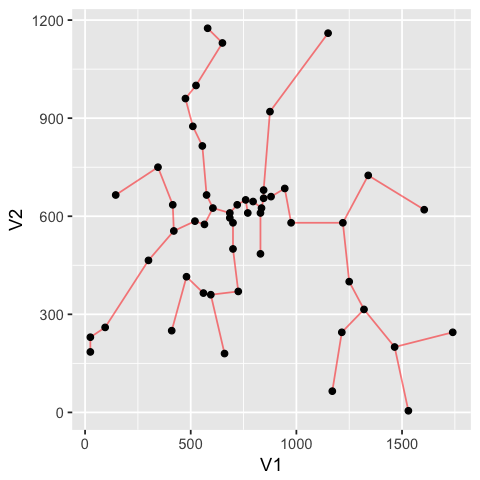

In [23]:
options(repr.plot.width = 4, repr.plot.height = 4)

y <- SolveMinimumSpanningTree(dist(berlin.52))
cbind(berlin.52[y[, 1], ], berlin.52[y[, 2], ]) %>% 
as.data.frame() %>%
ggplot() +
    geom_segment(aes(x = V1, y = V2, xend = V3, yend = V4),colour="red",alpha=0.5) +
    geom_point(data = as.data.frame(berlin.52), aes(x = V1, y = V2))


##### st.70

TODO(@garciparedes): Do Example.

In [24]:
st.70 <- 
    "st70.dat" %>%
    { paste0(dataset.folder, .) } %>%
    ReadCoordinatedFile()

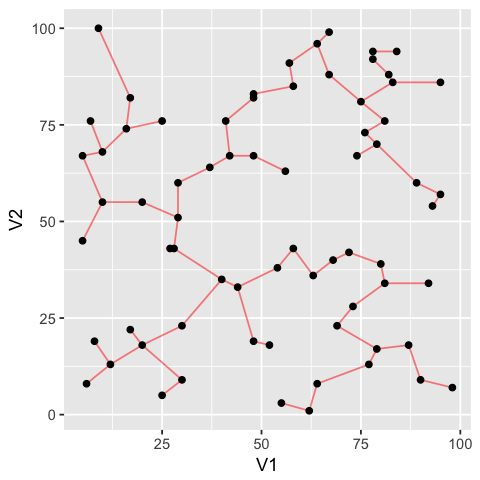

In [25]:
options(repr.plot.width = 4, repr.plot.height = 4)

y <- SolveMinimumSpanningTree(dist(st.70))
cbind(st.70[y[,1], ], st.70[y[,2], ]) %>% 
as.data.frame %>%
ggplot() +
    geom_segment(aes(x = V1, y = V2, xend = V3, yend = V4),colour="red",alpha=0.5) +
    geom_point(data = as.data.frame(st.70), aes(x = V1, y = V2))


##### a.280

TODO(@garciparedes): Do Example.

In [26]:
a.280 <- 
    "a280.dat" %>%
    { paste0(dataset.folder, .) } %>%
    ReadCoordinatedFile()

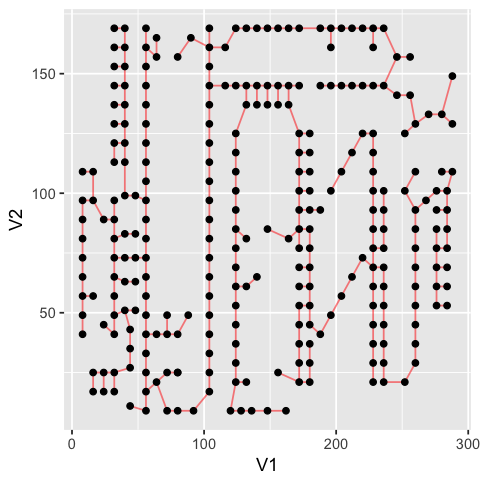

In [27]:
options(repr.plot.width = 4, repr.plot.height = 4)

y <- SolveMinimumSpanningTree(dist(a.280))
cbind(a.280[y[,1], ], a.280[y[,2], ]) %>% 
as.data.frame %>%
ggplot() +
    geom_segment(aes(x = V1, y = V2, xend = V3, yend = V4),colour="red",alpha=0.5) +
    geom_point(data = as.data.frame(a.280), aes(x = V1, y = V2))


##### gr15.{1,...,5}

TODO(@garciparedes): Do Example.

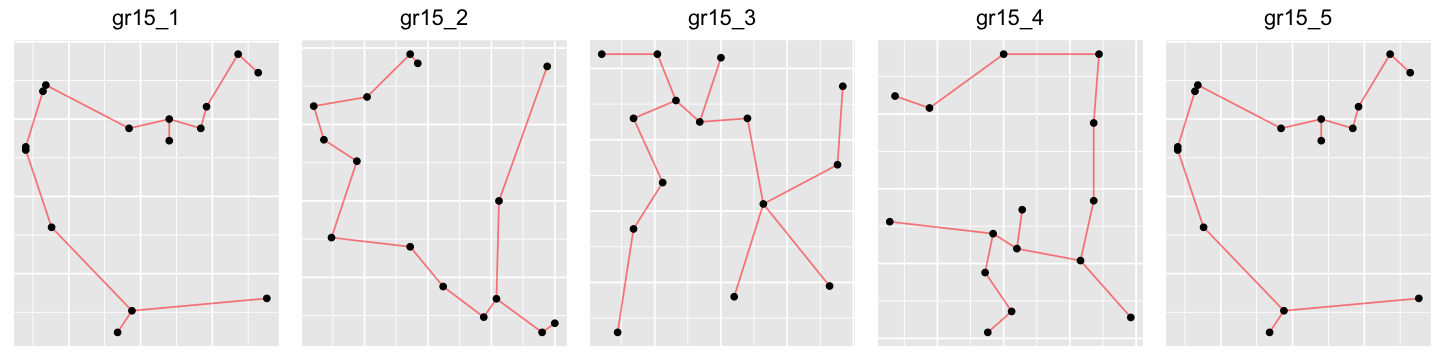

In [28]:
options(repr.plot.width = 12, repr.plot.height = 3)

gr <- c("gr15_1", "gr15_2", "gr15_3", "gr15_4", "gr15_5") 

gr %>%
lapply(function(f) {
    p <- paste0(f, ".dat") %>%
    { paste0(dataset.folder, .) } %>%
    ReadCoordinatedFile()
    y <- SolveMinimumSpanningTree(dist(p))
    cbind(p[y[,1], ], p[y[,2], ]) %>% 
    as.data.frame %>%
    ggplot() +
        geom_segment(aes(x = V1, y = V2, xend = V3, yend = V4),colour="red",alpha=0.5) +
        geom_point(data = as.data.frame(p), aes(x = V1, y = V2)) +

        ggtitle(f) +
            theme(plot.title   = element_text(hjust = 0.5),
                  axis.title.x = element_blank(),
                  axis.text.x  = element_blank(),
                  axis.ticks.x = element_blank(), 
                  axis.title.y = element_blank(),
                  axis.text.y  = element_blank(),
                  axis.ticks.y = element_blank())
}) %>%
{ do.call("grid.arrange", c(., ncol = 5)) }


### Árbol Recubridor Mínimo Capacitado

#### Descripción

TODO

#### Modelo

TODO

#### Ejemplos

TODO

##### gr15.{1,...,5}

TODO(@garciparedes): Do Example.

In [29]:
WriteListToMoselData <- function(file.path, p) {
    s <- ""
    for(i in 1:length(p)) {
        s <- paste0(s, names(p)[i],": ")
              
        if (is.vector(p[[i]])) {
            s <- paste0(s, p[[i]])
        } else {
            s <- paste0(s, "[", paste(round(t(p[[i]]), digits = 4), collapse=' '), "]")
        } 
        s <- paste0(s, '\n')
    }
    
    fileConn<-file(file.path)
    writeLines(s, fileConn)
    close(fileConn)
}

In [30]:
ReadEdgesList <- function(file.path) {
    read.csv(file.path, header  = TRUE)
}

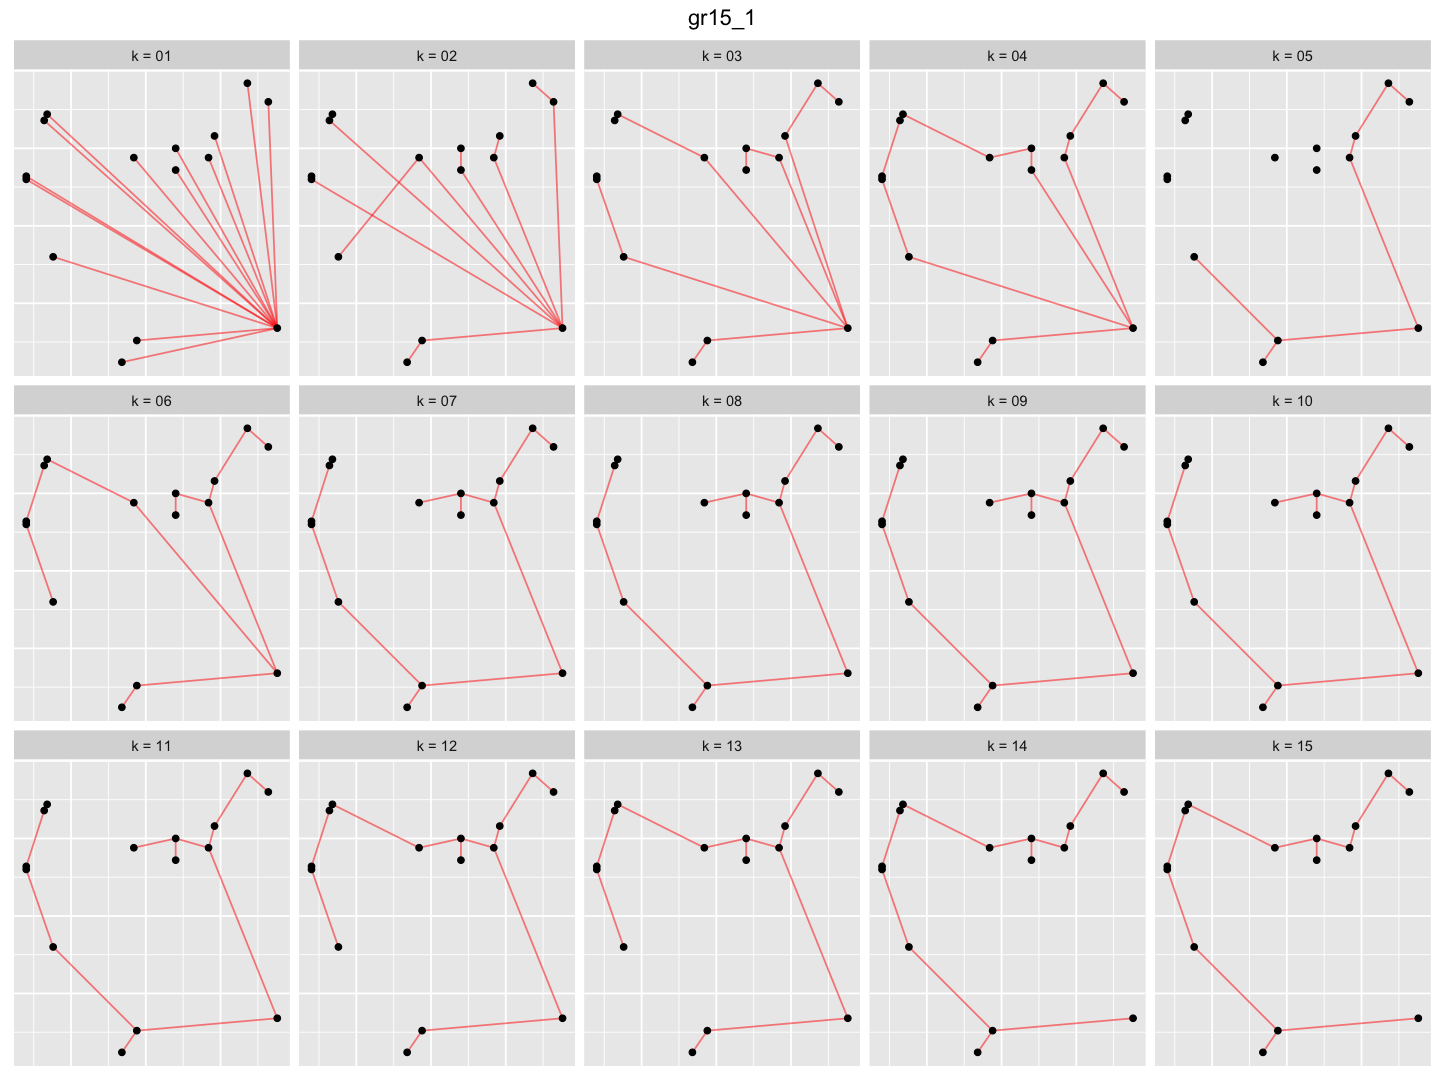

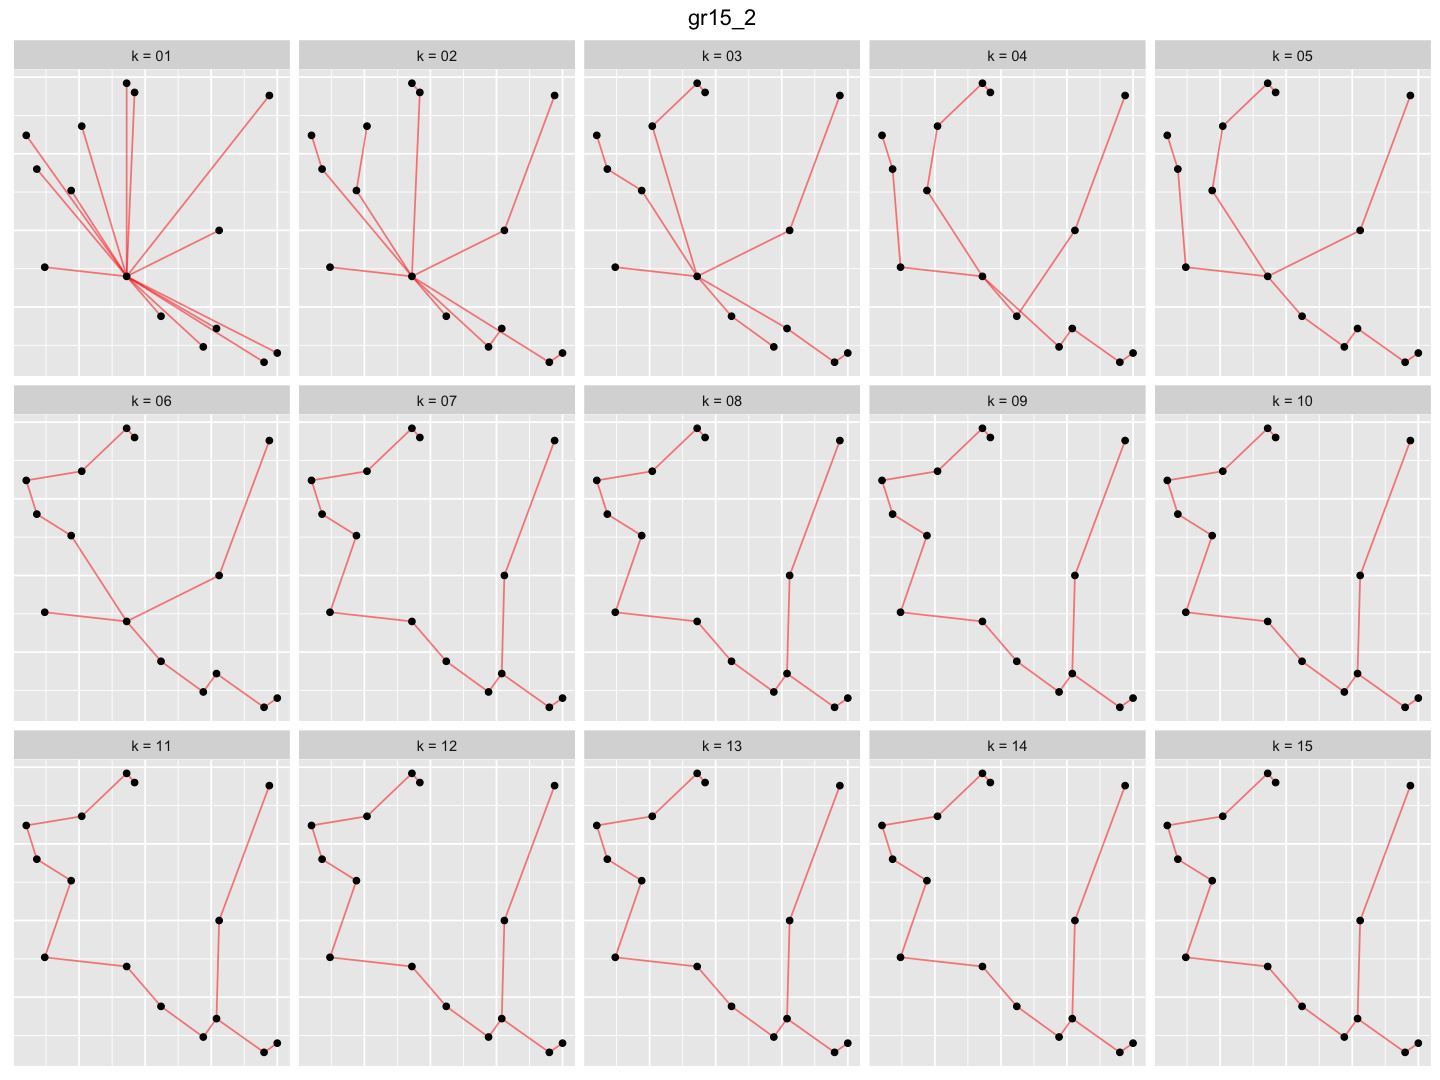

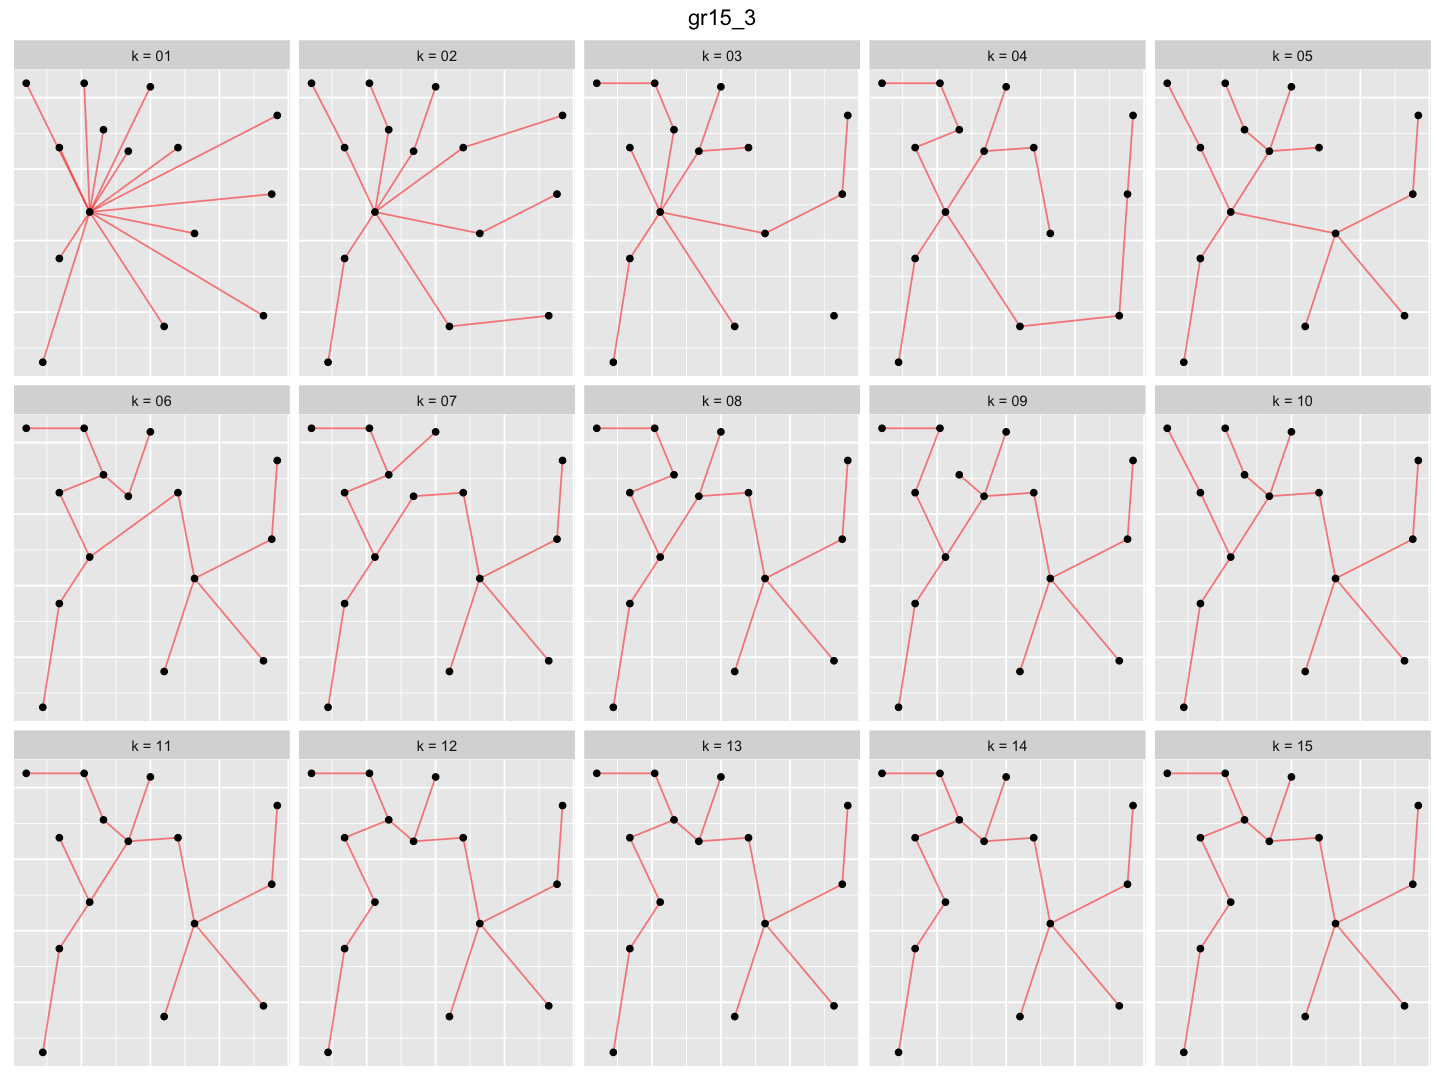

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]


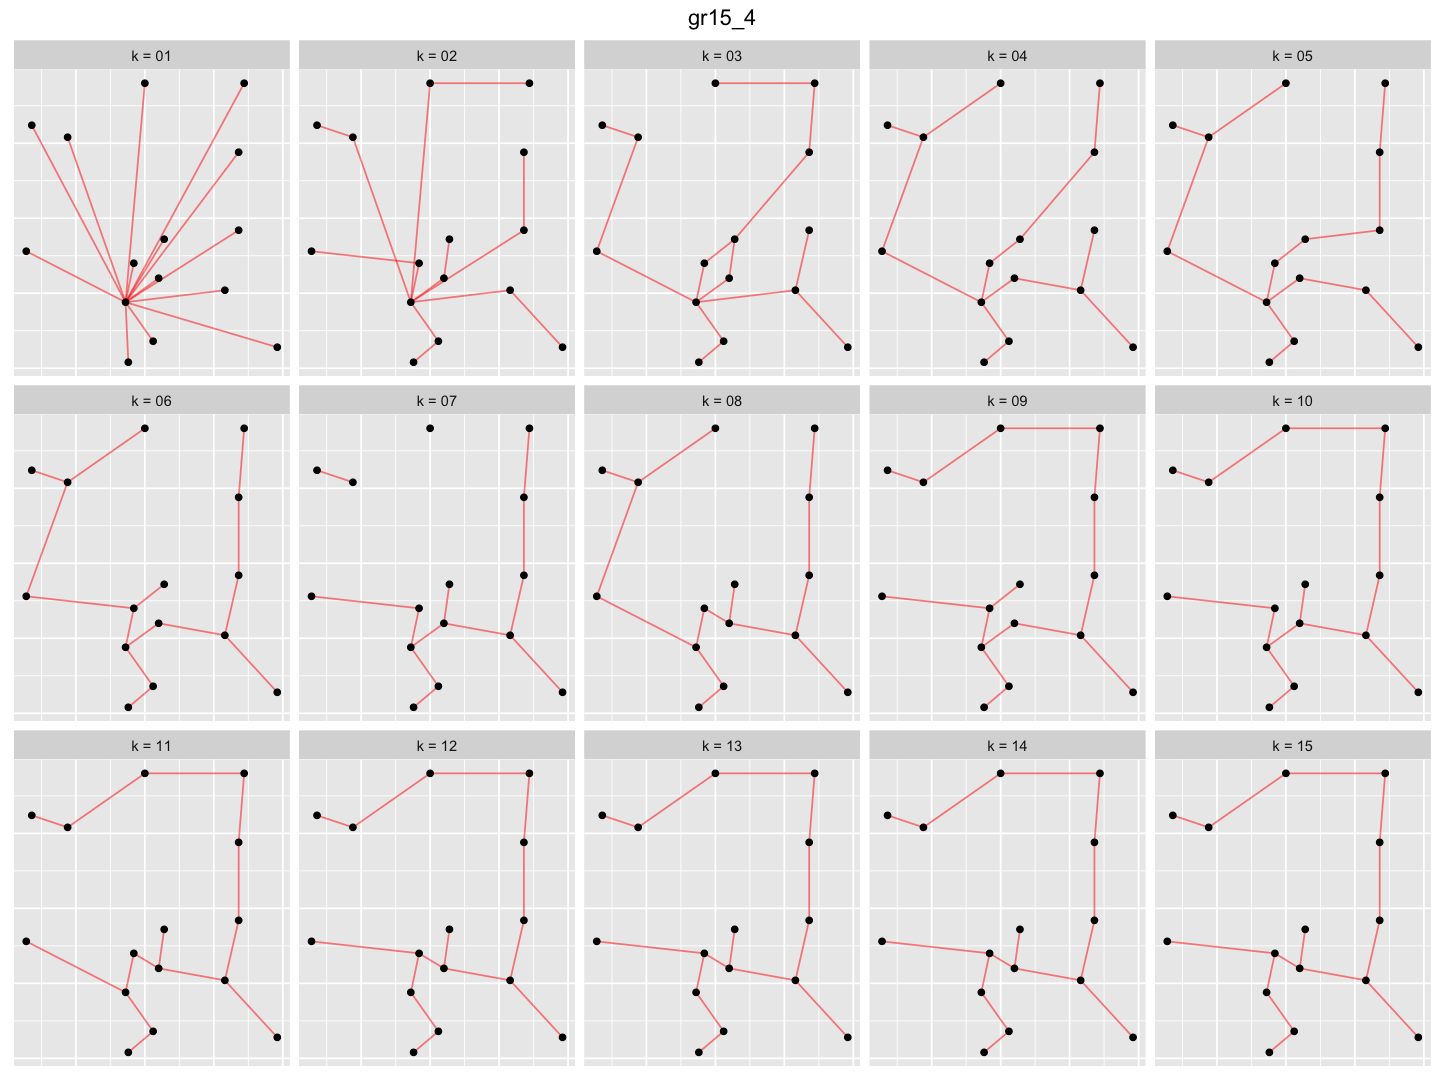

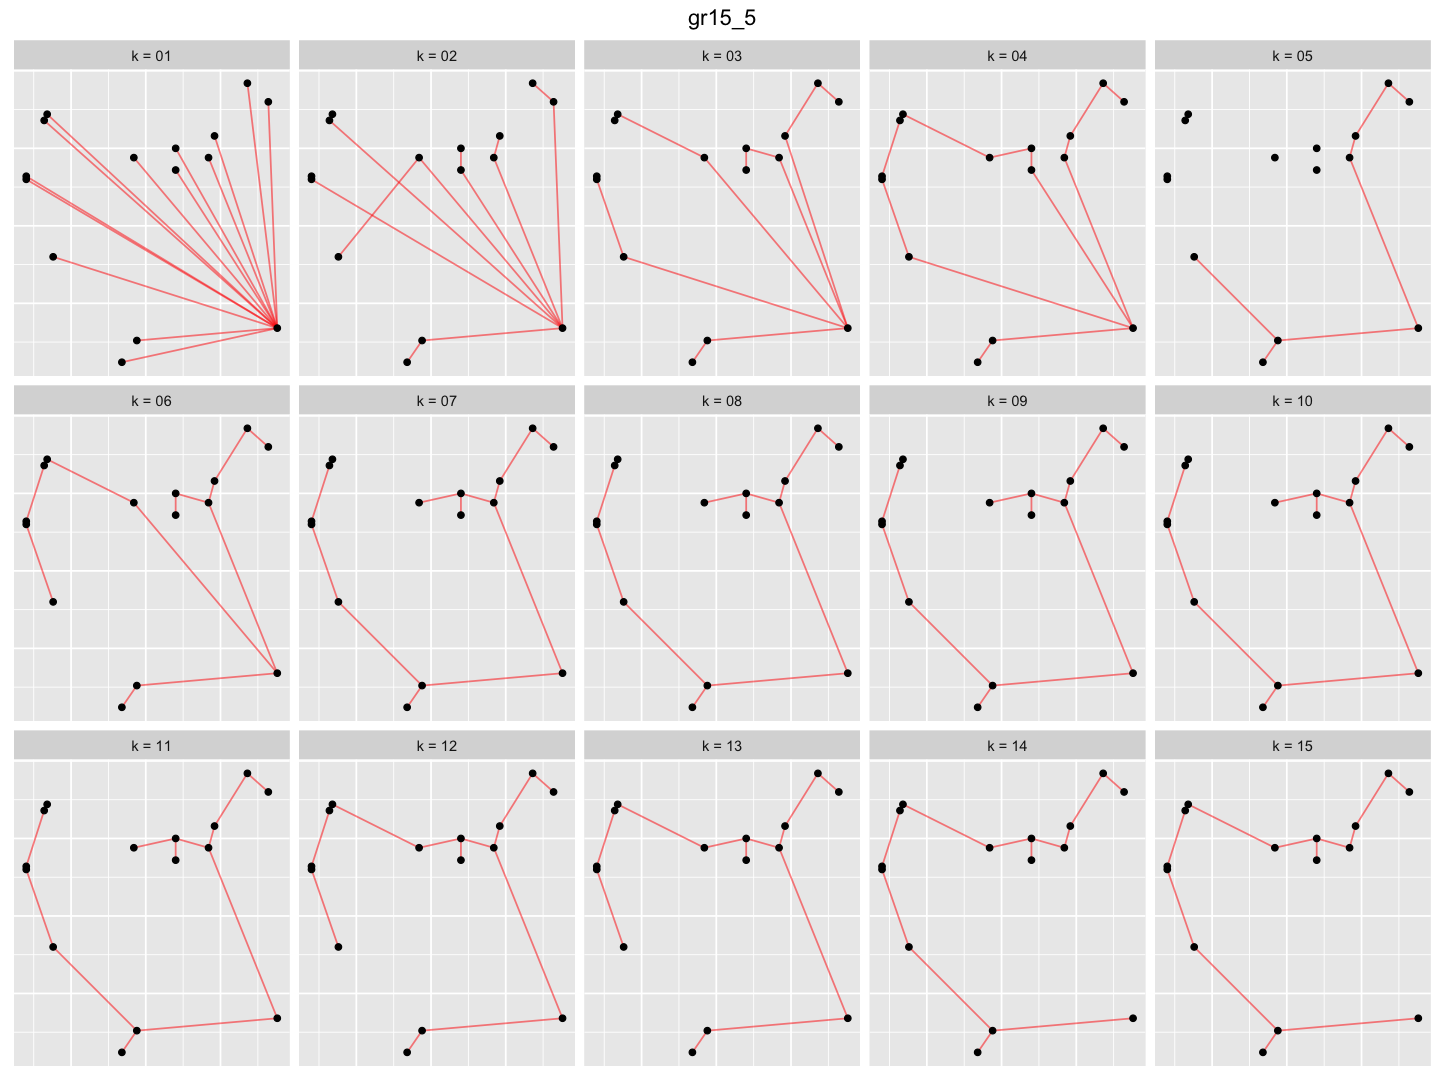

In [31]:
options(repr.plot.width = 12, repr.plot.height = 9)
c("gr15_1", "gr15_2", "gr15_3", "gr15_4", "gr15_5")  %>%
lapply(function(f) {
    p <- paste0(f, ".dat") %>%
    { paste0(dataset.folder, .) } %>%
    ReadCoordinatedFile()
    
    WriteListToMoselData(paste0(dataset.mosel, "mosel_input_", f, ".dat"), list(n = nrow(p), 
          b = matrix(c(14, rep(-1, 14)), ncol = 1), 
          A = as.matrix(dist(p))))
    seq(1, nrow(p)) %>% 
    lapply(function(n) {
        y <- 
            paste0(dataset.mosel, "mosel_output_", f, "_", n, ".csv") %>%
            ReadEdgesList()
        cbind(p[y[,1], ], p[y[,2], ]) %>% 
        as.data.frame()
    }) %>% 
    map_df(I, .id = "k") %>%
    mutate(k = sprintf("k = %02d", as.numeric(k))) %>%
    ggplot() +
        geom_segment(aes(x = V1, y = V2, xend = V3, yend = V4),colour="red", alpha=0.5) +
        geom_point(data = as.data.frame(p), aes(x = V1, y = V2)) +
        facet_wrap(~ k, ncol = 5)  + 
        ggtitle(f) +
        theme(plot.title   = element_text(hjust = 0.5),
              axis.title.x = element_blank(),
              axis.text.x  = element_blank(),
              axis.ticks.x = element_blank(), 
              axis.title.y = element_blank(),
              axis.text.y  = element_blank(),
              axis.ticks.y = element_blank())
});

### Problema de Steiner

#### Descripción

TODO

#### Modelo

TODO

#### Ejemplos

TODO

##### grafo.11.nodos

TODO(@garciparedes): Do Example.

##### gr15.{1,...,5}

TODO(@garciparedes): Do Example.

## Conclusiones

TODO

## Referencias

  * [TRC13] Team, R.C., 2013. R: A language and environment for statistical computing.
  * [GP18] Sergio García Prado. Programación Entera: Heurísticas, 2018. [github.com/garciparedes/integer-programming-heuristics](https://github.com/garciparedes/integer-programming-heuristics).
  * [SA18] Jesús Sáez Aguado. Programación Entera, 2017/18. Facultad de Ciencias: Departamento de Estadística e Investigación Operativa.
  * [THBSST17] Theussl, S., Hornik, K., Buchta, C., Schwendinger, F., Schuchardt, H. and Theussl, M.S., 2017. Package ‘Rglpk’.
  